주제 : 자동차 번호판 비식별화

목적(동기)
- 새로운 비식별화 방법 제안 (비식별화를 하는데 자연스럽게 변환된 결과가 나오는 모델을 만들고자 한다)
- 목적 달성을 위한 domain을 자동차 번호판으로 설정

Challenge
- 기존 목표 : 자동차 번호판을 랜덤한(읽을 수 있는) 문자로 대체하려고 했음 -> 기존 이미지 부분 편집
- 시도했던 모델 : InstructPix2Pix
- 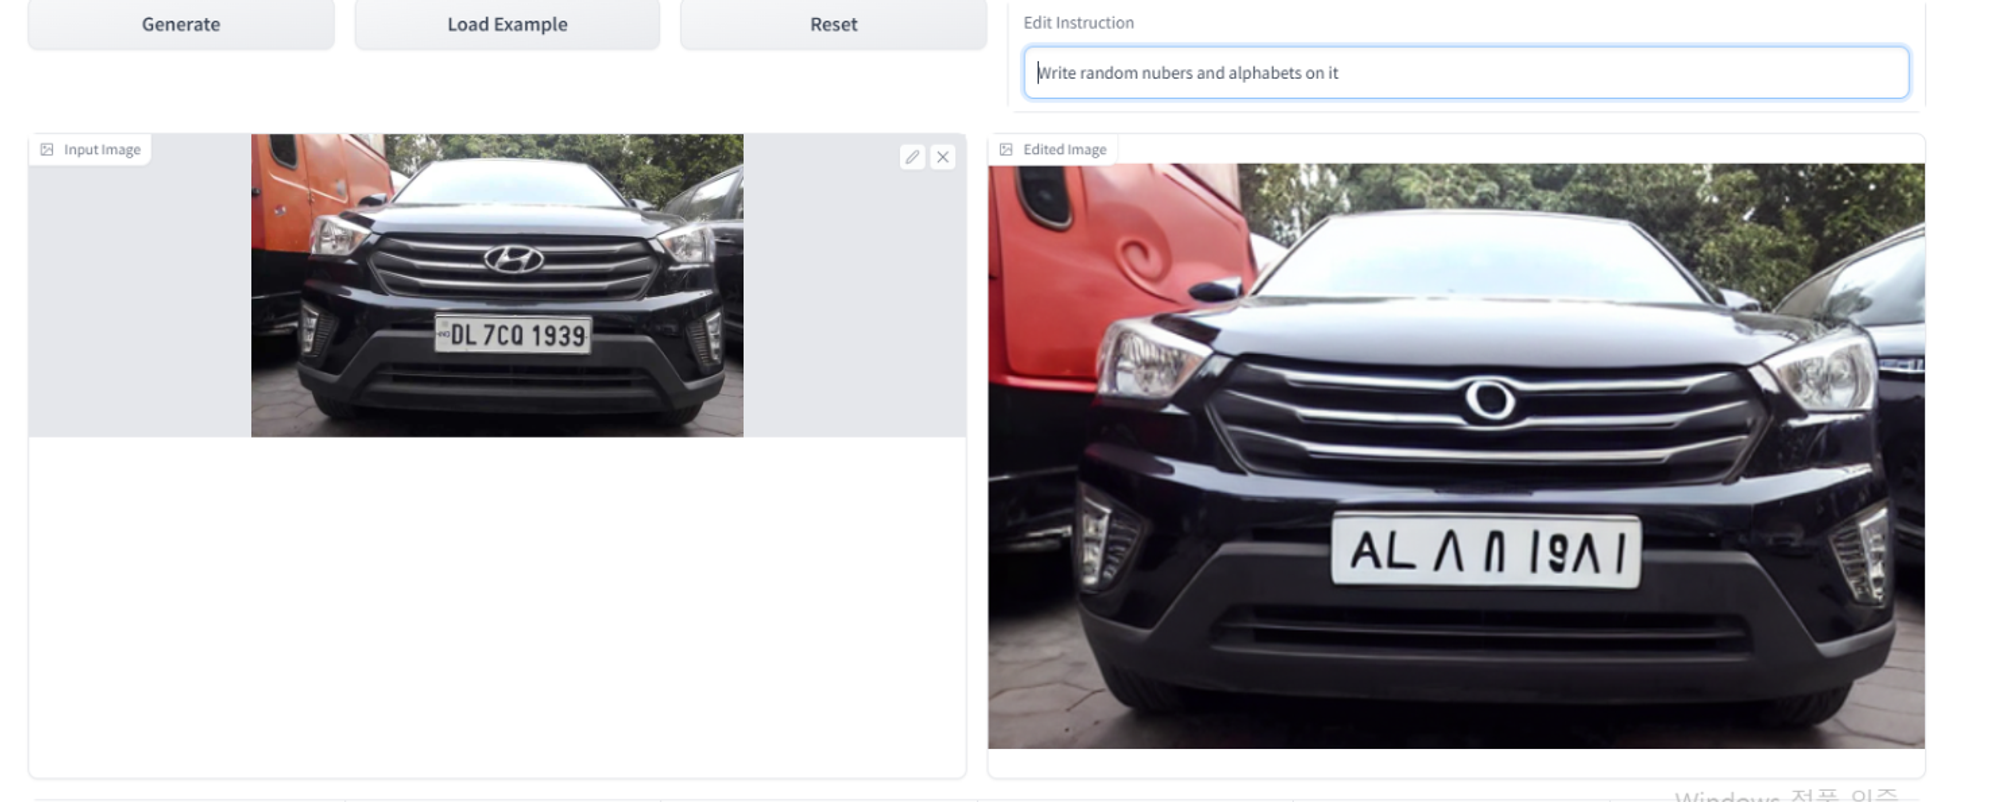
- 입력했던 Instruction : Write random numbers and alphabets on the car number plate -> 제일 결과물이 좋았었음!
- 이 모델을 사용하여 기존 이미지를 편집하려고 했음(Learning to Follow Image Editing Instructions)
- 작동법 : 사용자가 Instruction(문장)을 넣으면 해당 instruction대로 편집해주는 모델
- 결과 : 한번에 인식하기 어려운 문자를 Ouput으로 받음, 다른 방법 모색

Inpainting
- https://blog.naver.com/dmswlskim/222392601484 읽어보면 좋을듯
- 기존 목표의 대체제로 inpainting을 고안
- inpainting 설명~~~~


데이터셋
- https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
- https://public.roboflow.com/object-detection/license-plates-us-eu
- 데이터를 모두 합친 후 train/val/test = 8:1:1 split
- train/val/test = 625:79:79


PyTorch사용
- PyTorch는 Python을 위한 오픈소스 머신 러닝 라이브러리

In [ ]:
# 데이터셋 나누기
import os
from sklearn.model_selection import train_test_split
import shutil

def split_data(input_folder, output_folder, test_size=0.1, val_size=0.1, random_state=42):
    # 이미지 파일 리스트 가져오기
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

    # Train/Test 데이터 나누기
    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=random_state)

    # Train/Validation 데이터 나누기
    train_files, val_files = train_test_split(train_files, test_size=val_size / (1 - test_size), random_state=random_state)

    # Train 폴더 생성
    train_folder = os.path.join(output_folder, "train")
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)

    # Validation 폴더 생성
    val_folder = os.path.join(output_folder, "val")
    if not os.path.exists(val_folder):
        os.makedirs(val_folder)

    # Test 폴더 생성
    test_folder = os.path.join(output_folder, "test")
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    # Train 데이터 복사
    for file_name in train_files:
        source_path = os.path.join(input_folder, file_name)
        destination_path = os.path.join(train_folder, file_name)
        shutil.copyfile(source_path, destination_path)

    # Validation 데이터 복사
    for file_name in val_files:
        source_path = os.path.join(input_folder, file_name)
        destination_path = os.path.join(val_folder, file_name)
        shutil.copyfile(source_path, destination_path)

    # Test 데이터 복사
    for file_name in test_files:
        source_path = os.path.join(input_folder, file_name)
        destination_path = os.path.join(test_folder, file_name)
        shutil.copyfile(source_path, destination_path)

# 입력 폴더와 출력 폴더 지정
input_folder_path = './dataset/all' # 2개의 데이터셋을 하나로 합침
output_folder_path = './dataset/splitted_data' #결과 저장, splitted_data 폴더 안에는 train/val/test 폴더 생성되며 각 폴더에 이미지 저장됨

# 함수 호출 (test_size와 val_size, random_state는 필요에 따라 조절 가능)
split_data(input_folder_path, output_folder_path, test_size=0.1, val_size=0.1, random_state=42)

필요한 라이브러리 등 import

In [ ]:

import os
import random
import time
import shutil
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
from tensorboardX import SummaryWriter

from trainer import Trainer
import torchvision.transforms as transforms

from data.dataset import Dataset
from utils.tools import get_config, random_bbox, mask_image, is_image_file, default_loader, get_model_list, normalize
from utils.logger import get_logger
from model.networks import Generator
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv

torch.autograd.set_detect_anomaly(True)

parser = ArgumentParser()
parser.add_argument('--config', type=str, default='configs/config.yaml',
                    help="training configuration")
parser.add_argument('--seed', type=int, help='manual seed')





평가지표
- 보통의 GAN모델에서는 Inception Score나 SSIM를 사용 -> 이유 : 원본을 얼마나 잘 복원을 했는가에 대한 평가
- However, 우리 모델구조에서는 원본을 잘 복원하는 것이 목표이 아니기 때문에 적합하지 않음
- 우리가 선택한 지표 : PSNR, Total Variation Loss(TV Loss) 인데
- PSNR, TV Loss 선택한 이유 : 참고한 논문에서 활용

- PSNR(Peak Signal-to-Noise Ratio) : 
    - 화질의 손실 정보를 평가할 때 사용, 즉 MSE값이 작으면 원본과 가깝다 = PSNR이 높다
    - PSNR이 높다는것은 무조건 고해상도를 뜻하지는 않는다.
    - https://dbstndi6316.tistory.com/376 : 설명할때 이미지 가져오면 좋을 것 같다
    

- TV Loss(Total Variation Loss)
    - 단일 이미지의 image의 수직축 수평축 각각에 대해 옆 픽셀간의 variation(변화량)을 구하고 summation합니다
    - 참고 : https://xoft.tistory.com/55

In [ ]:
# Validation


# Validation 데이터셋에 대하여 평가 및 loss구하기.
# Calculate performance metric of validation dataset.
def validate(trainer, val_loader, config, iteration, writer, device):
    trainer.eval() # 모델 평가 모드
    total_loss_d = 0.0 # Discriminator의 loss
    total_loss_g = 0.0 # Generator의 loss
    # 위의 두개를 구한 이유는 각 loss의 간격이 가장 좁은 구간의 iter선택을 하기 위해
    
    # 우리가 고른 평가지표
    total_loss_tv = 0.0
    total_psnr = 0.0

    iterable_val_loader = iter(val_loader) # data loader 불러오기
    trainer_module = trainer.module
    start_iteration = trainer_module.resume(config['resume']) if config['resume'] else 1
    
    try:
        ground_truth = next(iterable_val_loader) # ground_truth : 원본 이미지
    except StopIteration:
        iterable_val_loader = iter(val_loader)
        ground_truth = next(iterable_val_loader)

    # Prepare the inputs
    """
    Random_bbox : Generate a random tlhw with configuration.

    Args:
        config: Config should have configuration including img

    Returns:
        tuple: (top, left, height, width)

    """
    
    bboxes = random_bbox(config, batch_size=ground_truth.size(0))
    # x : masking된 이미지
    # mask : mask 그 자체 (흰색, 검은색 네모)
    x, mask = mask_image(ground_truth, bboxes, config)
    
    
    
    if device:
        x = x.cuda()
        mask = mask.cuda()
        ground_truth = ground_truth.cuda()
    

    # Perform inference
    # losses : losses가 담겼다
    # inpainted_result : 생성된 이미지 (결과값)
    losses, inpainted_result, _ = trainer(x, bboxes, mask, ground_truth)

    # 각 loss에 대한 평균
    for k in losses.keys():
        if not losses[k].dim() == 0:
            losses[k] = torch.mean(losses[k])

    # discriminator loss
    losses['d'] = losses['wgan_d'] + losses['wgan_gp'] * config['wgan_gp_lambda']
    # generator loss
    losses['g'] = losses['l1'] * config['l1_loss_alpha'] \
            + losses['ae'] * config['ae_loss_alpha'] \
            + losses['wgan_g'] * config['gan_loss_alpha']

    # Calculate TV loss : 생성된 이미지를 통해 구함
    tv_loss = torch.sum(torch.abs(inpainted_result[:, :, :, :-1] - inpainted_result[:, :, :, 1:])) + \
            torch.sum(torch.abs(inpainted_result[:, :, :-1, :] - inpainted_result[:, :, 1:, :]))

    # Calculate PSNR (원본과 inpainted 결과를 비교하여 계산)
    psnr_value = calculate_psnr(ground_truth, inpainted_result)

    # Accumulate the validation loss
    total_loss_d += losses['d'].item()
    total_loss_g += losses['g'].item()  # Add this line
    total_loss_tv += tv_loss.item()  # Add this line
    total_psnr += psnr_value


    # Calculate average validation loss
    avg_loss_d = total_loss_d / len(val_loader)
    avg_loss_g = total_loss_g / len(val_loader)  # Add this line
    avg_loss_tv = total_loss_tv / len(val_loader)
    avg_psnr = total_psnr / len(val_loader)

    # Print or log the average validation loss
    print(f'Average Validation Loss (Discriminator): {avg_loss_d}')
    print(f'Average Validation Loss (Generator): {avg_loss_g}')  # Add this line
    print(f'Average Validation Loss (TV): {avg_loss_tv}')
    print(f'Average Validation PSNR: {avg_psnr}')

    writer.add_scalar('val_loss_d', avg_loss_d, iteration)
    writer.add_scalar('val_loss_g', avg_loss_g, iteration)  # Add this line

    return avg_loss_tv, avg_loss_d, avg_loss_g, avg_psnr


# Calculate PSNR for performance metric
def calculate_psnr(original, restored, max_value=1.0):
    mse = torch.mean((original - restored) ** 2)
    psnr = 20 * torch.log10(max_value / torch.sqrt(mse))
    return psnr.item()






데이터셋 전처리
- 데이터셋 Load하고 전처리, DataLoader(Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌈)로 옮김
- 밑에 데이터 로더하는 부분 주석 읽어보기!
- 밑의 클래스는 data/dataset.py 코드 일부이며, 해당 클래스를 통해 데이터셋을 불러옴!

class Dataset(data.Dataset):
    def __init__(self, data_path, image_shape, with_subfolder=False, random_crop=True, return_name=False):
        super(Dataset, self).__init__()
        if with_subfolder:
            self.samples = self._find_samples_in_subfolders(data_path)
        else:
            self.samples = [x for x in listdir(data_path) if is_image_file(x)]
        self.data_path = data_path
        self.image_shape = image_shape[:-1]
        self.random_crop = random_crop
        self.return_name = return_name

    def __getitem__(self, index):
        path = os.path.join(self.data_path, self.samples[index])
        # path = os.path.join(self.data_path)

        img = default_loader(path)

        if self.random_crop:
            imgw, imgh = img.size
            if imgh < self.image_shape[0] or imgw < self.image_shape[1]:
                img = transforms.Resize(min(self.image_shape))(img)
            img = transforms.RandomCrop(self.image_shape)(img)
        else:
            img = transforms.Resize(self.image_shape)(img)
            img = transforms.RandomCrop(self.image_shape)(img)

        img = transforms.ToTensor()(img)  # turn the image to a tensor
        img = normalize(img)

        if self.return_name:
            return self.samples[index], img
        else:
            return img

모델 훈련(Trainer 클래스)
각 함수 설명 정도?

import os
import torch
import torch.nn as nn
from torch import autograd
from model.networks import Generator, LocalDis, GlobalDis


from utils.tools import get_model_list, local_patch, spatial_discounting_mask
from utils.logger import get_logger

logger = get_logger()


class Trainer(nn.Module):
    def __init__(self, config):
        super(Trainer, self).__init__()
        self.config = config
        self.use_cuda = self.config['cuda']
        self.device_ids = self.config['gpu_ids']

        self.netG = Generator(self.config['netG'], self.use_cuda, self.device_ids)
        self.localD = LocalDis(self.config['netD'], self.use_cuda, self.device_ids)
        self.globalD = GlobalDis(self.config['netD'], self.use_cuda, self.device_ids)

        self.optimizer_g = torch.optim.Adam(self.netG.parameters(), lr=self.config['lr'],
                                            betas=(self.config['beta1'], self.config['beta2']))
        d_params = list(self.localD.parameters()) + list(self.globalD.parameters())
        self.optimizer_d = torch.optim.Adam(d_params, lr=config['lr'],
                                            betas=(self.config['beta1'], self.config['beta2']))
        if self.use_cuda:
            self.netG.to(self.device_ids[0])
            self.localD.to(self.device_ids[0])
            self.globalD.to(self.device_ids[0])

    def forward(self, x, bboxes, masks, ground_truth, compute_loss_g=False):
        self.train()
        l1_loss = nn.L1Loss()
        losses = {}

        x1, x2, offset_flow = self.netG(x, masks)
        local_patch_gt = local_patch(ground_truth, bboxes)
        x1_inpaint = x1 * masks + x * (1. - masks)
        x2_inpaint = x2 * masks + x * (1. - masks)
        local_patch_x1_inpaint = local_patch(x1_inpaint, bboxes)
        local_patch_x2_inpaint = local_patch(x2_inpaint, bboxes)

        # D part
        # wgan d loss
        local_patch_real_pred, local_patch_fake_pred = self.dis_forward(
            self.localD, local_patch_gt, local_patch_x2_inpaint.detach())
        global_real_pred, global_fake_pred = self.dis_forward(
            self.globalD, ground_truth, x2_inpaint.detach())
        losses['wgan_d'] = torch.mean(local_patch_fake_pred - local_patch_real_pred) + \
            torch.mean(global_fake_pred - global_real_pred) * self.config['global_wgan_loss_alpha']
        # gradients penalty loss
        local_penalty = self.calc_gradient_penalty(
            self.localD, local_patch_gt, local_patch_x2_inpaint.detach())
        global_penalty = self.calc_gradient_penalty(self.globalD, ground_truth, x2_inpaint.detach())
        losses['wgan_gp'] = local_penalty + global_penalty

        # G part
        if compute_loss_g:
            sd_mask = spatial_discounting_mask(self.config)
            losses['l1'] = l1_loss(local_patch_x1_inpaint * sd_mask, local_patch_gt * sd_mask) * \
                self.config['coarse_l1_alpha'] + \
                l1_loss(local_patch_x2_inpaint * sd_mask, local_patch_gt * sd_mask)
            losses['ae'] = l1_loss(x1 * (1. - masks), ground_truth * (1. - masks)) * \
                self.config['coarse_l1_alpha'] + \
                l1_loss(x2 * (1. - masks), ground_truth * (1. - masks))

            # wgan g loss
            local_patch_real_pred, local_patch_fake_pred = self.dis_forward(
                self.localD, local_patch_gt, local_patch_x2_inpaint)
            global_real_pred, global_fake_pred = self.dis_forward(
                self.globalD, ground_truth, x2_inpaint)
            losses['wgan_g'] = - torch.mean(local_patch_fake_pred) - \
                torch.mean(global_fake_pred) * self.config['global_wgan_loss_alpha']

        return losses, x2_inpaint, offset_flow

    def dis_forward(self, netD, ground_truth, x_inpaint):
        assert ground_truth.size() == x_inpaint.size()
        batch_size = ground_truth.size(0)
        batch_data = torch.cat([ground_truth, x_inpaint], dim=0)
        batch_output = netD(batch_data)
        real_pred, fake_pred = torch.split(batch_output, batch_size, dim=0)

        return real_pred, fake_pred

    # Calculate gradient penalty
    def calc_gradient_penalty(self, netD, real_data, fake_data):
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()

        interpolates = alpha * real_data + (1 - alpha) * fake_data
        interpolates = interpolates.requires_grad_().clone()

        disc_interpolates = netD(interpolates)
        grad_outputs = torch.ones(disc_interpolates.size())

        if self.use_cuda:
            grad_outputs = grad_outputs.cuda()

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=grad_outputs, create_graph=True,
                                  retain_graph=True, only_inputs=True)[0]

        gradients = gradients.view(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

        return gradient_penalty

    def inference(self, x, masks):
        self.eval()
        x1, x2, offset_flow = self.netG(x, masks)
        # x1_inpaint = x1 * masks + x * (1. - masks)
        x2_inpaint = x2 * masks + x * (1. - masks)

        return x2_inpaint, offset_flow

    def save_model(self, checkpoint_dir, iteration):
        # Save generators, discriminators, and optimizers
        gen_name = os.path.join(checkpoint_dir, 'gen_%08d.pt' % iteration)
        dis_name = os.path.join(checkpoint_dir, 'dis_%08d.pt' % iteration)
        opt_name = os.path.join(checkpoint_dir, 'optimizer.pt')
        torch.save(self.netG.state_dict(), gen_name)
        torch.save({'localD': self.localD.state_dict(),
                    'globalD': self.globalD.state_dict()}, dis_name)
        torch.save({'gen': self.optimizer_g.state_dict(),
                    'dis': self.optimizer_d.state_dict()}, opt_name)

    def resume(self, checkpoint_dir, iteration=0, test=False):
        # Load generators
        last_model_name = get_model_list(checkpoint_dir, "gen", iteration=iteration)
        self.netG.load_state_dict(torch.load(last_model_name))
        iteration = int(last_model_name[-11:-3])

        if not test:
            # Load discriminators
            last_model_name = get_model_list(checkpoint_dir, "dis", iteration=iteration)
            state_dict = torch.load(last_model_name)
            self.localD.load_state_dict(state_dict['localD'])
            self.globalD.load_state_dict(state_dict['globalD'])
            # Load optimizers
            state_dict = torch.load(os.path.join(checkpoint_dir, 'optimizer.pt'))
            self.optimizer_d.load_state_dict(state_dict['dis'])
            self.optimizer_g.load_state_dict(state_dict['gen'])

        print("Resume from {} at iteration {}".format(checkpoint_dir, iteration))
        logger.info("Resume from {} at iteration {}".format(checkpoint_dir, iteration))

        return iteration

In [ ]:
# 메인함수 시작 : 훈련
def main():
    args = parser.parse_args()
    config = get_config(args.config)

    # Store values for visualization
    # 나중에 시각화 하려고 만든 리스트
    avg_loss_tv_list = []  
    avg_loss_g_list = []
    avg_loss_d_list = []
    avg_psnr_list = []

    # CUDA configuration : GPU 관련 부분
    cuda = config['cuda']
    device_ids = config['gpu_ids']
    if cuda:
        os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in device_ids)
        device_ids = list(range(len(device_ids)))
        config['gpu_ids'] = device_ids
        cudnn.benchmark = True

    # Configure checkpoint path
    # checkpoint : 훈련된 모델의 weight
    
    # 체크 포인트 저장 위치
    # 우리가 지정한 간격마다 저장되게 함
    checkpoint_path = os.path.join('checkpoints',
                                config['dataset_name'],
                                config['mask_type'] + '_' + config['expname'])
    
    # 체크포인트 경로가 없으면 디렉토리 생성
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    shutil.copy(args.config, os.path.join(checkpoint_path, os.path.basename(args.config)))
    writer = SummaryWriter(logdir=checkpoint_path)
    logger = get_logger(checkpoint_path)    # get logger and configure it at the first call

    logger.info("Arguments: {}".format(args))
    # Set random seed
    if args.seed is None:
        args.seed = random.randint(1, 10000)
    logger.info("Random seed: {}".format(args.seed))
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    if cuda:
        torch.cuda.manual_seed_all(args.seed)

    # Log the configuration
    logger.info("Configuration: {}".format(config))




    # 데이터셋 로드
    # 데이터셋 Load하고 전처리, DataLoader(Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌈)로 옮김
    try:  # for unexpected error logging
        # Load the dataset
        logger.info("Training on dataset: {}".format(config['dataset_name']))
        train_dataset = Dataset(data_path=config['train_data_path'],
                                with_subfolder=config['data_with_subfolder'], #False 무시해도 됨! (현재 우리 셋팅에서 데이터셋 폴더 구조가 dataset/train, dataset/val, dataset/test인데. 각 train/val/test안에 별도의 폴더가 없기 때문에 False로 하고 진행!)
                                image_shape=config['image_shape'], # 256,256 -> 인풋 사이즈가 항상 이거여야 함
                                random_crop=config['random_crop']) # 훈련시 256,256을 랜덤 위치로 크롭
        val_dataset = Dataset(data_path=config['val_data_path'],
                            with_subfolder=config['data_with_subfolder'],
                                image_shape=config['image_shape'],
                            random_crop=config['random_crop'])
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=config['batch_size'],
                                                shuffle=True,
                                                num_workers=config['num_workers'])
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                batch_size=config['batch_size'],
                                                shuffle=False,
                                                num_workers=config['num_workers'])

        # Define the trainer
        # Trainer클래스

        trainer = Trainer(config)
        logger.info("\n{}".format(trainer.netG))
        logger.info("\n{}".format(trainer.localD))
        logger.info("\n{}".format(trainer.globalD))

        if cuda:
            trainer = nn.parallel.DataParallel(trainer, device_ids=device_ids)
            trainer_module = trainer.module
        else:
            trainer_module = trainer

        # Get the resume iteration to restart training
        start_iteration = trainer_module.resume(config['resume']) if config['resume'] else 1

        iterable_train_loader = iter(train_loader)

        time_count = time.time()

        # Iteration 시작
        # niter가 우리가 지정
        for iteration in range(start_iteration, config['niter'] + 1):


            try:
                ground_truth = next(iterable_train_loader)
            except StopIteration:
                iterable_train_loader = iter(train_loader)
                ground_truth = next(iterable_train_loader)

            # Prepare the inputs
            bboxes = random_bbox(config, batch_size=ground_truth.size(0))
            x, mask = mask_image(ground_truth, bboxes, config)
            if cuda:
                x = x.cuda()
                mask = mask.cuda()
                ground_truth = ground_truth.cuda()

            ###### Forward pass ######
            compute_g_loss = iteration % config['n_critic'] == 0
            losses, inpainted_result, offset_flow = trainer(x, bboxes, mask, ground_truth, compute_g_loss)
            # Scalars from different devices are gathered into vectors
            for k in losses.keys():
                if not losses[k].dim() == 0:
                    losses[k] = torch.mean(losses[k])

            ###### Backward pass ###### Discriminator 역전파 후 웨이트 업데이트
            # Update D
            trainer_module.optimizer_d.zero_grad()
            losses['d'] = losses['wgan_d'] + losses['wgan_gp'] * config['wgan_gp_lambda']
            losses['d'].backward()
            # trainer_module.optimizer_d.step()

            ###### Update G Generator ###### 역전파 후 웨이트 업데이트
            if compute_g_loss:
                trainer_module.optimizer_g.zero_grad()
                losses['g'] = losses['l1'] * config['l1_loss_alpha'] \
                            + losses['ae'] * config['ae_loss_alpha'] \
                            + losses['wgan_g'] * config['gan_loss_alpha']
                losses['g'].backward()


                trainer_module.optimizer_d.step()
                trainer_module.optimizer_g.step()

            # Log and visualization
            log_losses = ['l1', 'ae', 'wgan_g', 'wgan_d', 'wgan_gp', 'g', 'd']
            if iteration % config['print_iter'] == 0:
                time_count = time.time() - time_count
                speed = config['print_iter'] / time_count
                speed_msg = 'speed: %.2f batches/s ' % speed
                time_count = time.time()

                message = 'Iter: [%d/%d] ' % (iteration, config['niter'])
                for k in log_losses:
                    v = losses.get(k, 0.)
                    writer.add_scalar(k, v, iteration)
                    message += '%s: %.6f ' % (k, v)
                message += speed_msg
                logger.info(message)
        
            # config파일에 지정한 간격마다 inpainted 된 결과(이미지) 저장. Checkpoint경로에 checkpoint와 함께 저장
            if iteration % (config['viz_iter']) == 0:
                viz_max_out = config['viz_max_out']
                if x.size(0) > viz_max_out:
                    viz_images = torch.stack([x[:viz_max_out], inpainted_result[:viz_max_out],
                                            offset_flow[:viz_max_out]], dim=1)
                else:
                    viz_images = torch.stack([x, inpainted_result, offset_flow], dim=1)
                viz_images = viz_images.view(-1, *list(x.size())[1:])
                vutils.save_image(viz_images,
                                '%s/niter_%03d.png' % (checkpoint_path, iteration),
                                nrow=3 * 4,
                                normalize=True)
                
            # validation 시각화를 위해
            avg_loss_tv, avg_loss_d, avg_loss_g, avg_psnr = validate(trainer, val_loader, config, iteration, writer, device=torch.device('cuda' if cuda else 'cpu'))
            avg_loss_tv_list.append(avg_loss_tv)  # append the value for visualization
            avg_loss_d_list.append(avg_loss_d)
            avg_loss_g_list.append(avg_loss_g)
            avg_psnr_list.append(avg_psnr)

            # Save the model
            if iteration % config['snapshot_save_iter'] == 0:
                trainer_module.save_model(checkpoint_path, iteration)


        # Save avg_loss_tv_list as a CSV file
        csv_file_path = ('./result/avg_loss_tv_list.csv')
        with open(csv_file_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Avg Loss TV'])
            for i, avg_loss_tv in enumerate(avg_loss_tv_list):
                csv_writer.writerow([avg_loss_tv])

        # Visualization of avg_loss_tv after training
        plt.plot(avg_loss_tv_list, label='avg_loss_tv')
        plt.title('Average TV Loss of Validation Set')
        plt.xlabel('Iteration')
        plt.ylabel('Average TV Loss')
        plt.legend()

        # Save the plot as an image
        plt.savefig('./result/train_tv_loss_plt')

        # Close the plot
        plt.close()

        # Save avg_loss_g_list as a CSV file
        csv_file_path = ('./result/avg_loss_g_list.csv')
        with open(csv_file_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Avg Loss G'])
            for i, avg_loss_g in enumerate(avg_loss_g_list):
                csv_writer.writerow([avg_loss_g])

        # Save avg_loss_d_list as a CSV file
        csv_file_path = ('./result/avg_loss_d_list.csv')
        with open(csv_file_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Avg Loss D'])
            for i, avg_loss_d in enumerate(avg_loss_d_list):
                csv_writer.writerow([avg_loss_d])

        # Visualization of avg_loss_g and avg_loss_d after training
        plt.plot(avg_loss_g_list, label='avg_loss_g')
        plt.plot(avg_loss_d_list, label='avg_loss_d')
        plt.title('Average Generator and Discriminator Loss of Validation Set')
        plt.xlabel('Iteration')
        plt.ylabel('Average Loss')
        plt.legend()

        # Save the plot as an image
        plt.savefig('./result/train_g_d_loss_plt')

        # Close the plot
        plt.close()

        csv_file_path = ('./result/avg_val_psnr.csv')
        with open(csv_file_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Avg Loss D'])
            for i, avg_psnr in enumerate(avg_psnr_list):
                csv_writer.writerow([avg_psnr])

        # Visualization of avg_psnr after training
        plt.plot(avg_psnr_list, label='avg_psnr')
        plt.title('Average PSNR of Validation Set')
        plt.xlabel('Iteration')
        plt.ylabel('Average PSNR')
        plt.legend()

        # Save the plot as an image
        plt.savefig('./result/train_psnr_plt')

        # Close the plot
        plt.close()
            
            

    except Exception as e:  # for unexpected error logging
        logger.error("{}".format(e))
        raise e


if __name__ == '__main__':
    main()


In [ ]:
# Inference Single Image (Test) - 퍼포먼스용(성능측정은 X)

import os
import random
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils

from model.networks import Generator
from utils.tools import get_config, is_image_file, default_loader, normalize, get_model_list

parser = ArgumentParser()
parser.add_argument('--config', type=str, default='configs/config.yaml', help="training configuration")
parser.add_argument('--seed', type=int, help='manual seed')
parser.add_argument('--image', type=str)
parser.add_argument('--output', type=str, default='output.png')
parser.add_argument('--checkpoint_path', type=str, default='')
parser.add_argument('--iter', type=int, default=0)
parser.add_argument('--x1', type=int, help='Top-left x-coordinate of the rectangular region')
parser.add_argument('--y1', type=int, help='Top-left y-coordinate of the rectangular region')
parser.add_argument('--x2', type=int, help='Bottom-right x-coordinate of the rectangular region')
parser.add_argument('--y2', type=int, help='Bottom-right y-coordinate of the rectangular region')


# 이 함수 설명 꼭 해주기! 번호판 좌표를 받아서 해당 부분만 inpaint되도록!
# Define the bbox2mask function for customised bbox according to coordinates
def bbox2mask(bbox, h, w):
    mask = torch.zeros((1, h, w), dtype=torch.float32)
    y1, x1, y2, x2 = bbox
    y1 = y1
    x1 = x1
    y2 = y2
    x2 = x2
    mask[:, y1:y2, x1:x2] = 1.0
    return mask


def main():
    args = parser.parse_args()
    config = get_config(args.config)


    # CUDA configuration
    cuda = config['cuda']
    device_ids = config['gpu_ids']
    if cuda:
        os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in device_ids)
        device_ids = list(range(len(device_ids)))
        config['gpu_ids'] = device_ids
        cudnn.benchmark = True

    print("Arguments: {}".format(args))

    # Set random seed
    if args.seed is None:
        args.seed = random.randint(1, 10000)
    print("Random seed: {}".format(args.seed))
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    if cuda:
        torch.cuda.manual_seed_all(args.seed)

    print("Configuration: {}".format(config))

    try:
        with torch.no_grad():
            if is_image_file(args.image):
                # Test a single ground-truth image with a mask at the specified rectangular region
                ground_truth = default_loader(args.image)
                ground_truth = transforms.ToTensor()(ground_truth)
                ground_truth = normalize(ground_truth)
                ground_truth = ground_truth.unsqueeze(dim=0)

                # Create a mask for the specified rectangular region
                mask = bbox2mask((args.y1, args.x1, args.y2, args.x2),
                                config['image_shape'][1], config['image_shape'][0])
                mask = mask.unsqueeze(dim=0)

                # Set checkpoint path
                if not args.checkpoint_path:
                    checkpoint_path = os.path.join('checkpoints', config['dataset_name'],
                                                   config['mask_type'] + '_' + config['expname'])
                else:
                    checkpoint_path = args.checkpoint_path

                # Define the trainer
                netG = Generator(config['netG'], cuda, device_ids)
                # Latest model
                # last_model_name = get_model_list(checkpoint_path, "gen", iteration=args.iter)
                last_model_name = get_model_list(checkpoint_path, "gen_00100000.pt")

                netG.load_state_dict(torch.load(last_model_name))
                model_iteration = args.iter
                print("Resume from {} at iteration {}".format(checkpoint_path, model_iteration))
                
                if cuda:
                    netG = nn.parallel.DataParallel(netG, device_ids=device_ids)
                    ground_truth = ground_truth.cuda()
                    mask = mask.cuda()

                # Inference
                x1, x2, offset_flow = netG(ground_truth, mask)
                inpainted_result = x2 * mask + ground_truth * (1. - mask)

                vutils.save_image(inpainted_result, args.output, padding=0, normalize=True)
                print("Saved the inpainted result to {}".format(args.output))
            else:
                raise TypeError("{} is not an image file.".format(args.image))
    except Exception as e:
        print("Error: {}".format(e))
        raise e

if __name__ == '__main__':
    main()


In [ ]:
# Test dataset 성능 측정 코드 추가!

결과
1. loss 함수 그래프 -> niter 결정! 그걸로 사용했다
2. PSNR 성능
3. TV loss 성능
4. test dataset에 대한 결과(PSNR, TV loss)